In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import neurom as nm
from bluepy import Circuit
import seaborn as sns
import blueetl
import re
import matplotlib.pyplot as plt

In [2]:
FEATURES = ["total_length", "total_height", "total_area", "number_of_sections", "section_lengths"]
NEURITES = {"apical": nm.core.types.NeuriteType.apical_dendrite,
            "basal": nm.core.types.NeuriteType.basal_dendrite,
            "axon": nm.core.types.NeuriteType.axon}


def get_features(morph_paths):
    """Get morphometric features for all morphologies passed"""
    features = {"mtype": [], "feature_name": [], "feature_val": [], "loc": []}
    for mtype, paths in tqdm(morph_paths.items(), desc="mtypes"):
        for path in tqdm(paths, desc="morphologies", miniters=len(paths)/100, leave=False):
            print(path)
            morph = nm.load_morphology(path)
            for neurite_name, neurite_id in NEURITES.items():
                for feature in FEATURES:
                    features["mtype"].append(mtype)
                    feature_name = "avg_section_length" if feature == "section_lengths" else feature
                    features["feature_name"].append(feature_name)
                    feature_val = nm.get(feature, morph, neurite_type=neurite_id)
                    feature_val = np.mean(feature_val) if feature == "section_lengths" else feature_val
                    features["feature_val"].append(feature_val)
                    features["loc"].append(neurite_name)
    df = pd.DataFrame.from_dict(features)
    #df.drop(df.loc[(df["mtype"] == "L4_SSC") & (df["loc"] == "apical")].index, inplace=True)  # clear L4_SSC apicals...
    return df

In [3]:
morph_folder = '/gpfs/bbp.cscs.ch/project/proj112/entities/morphologies/20211019/10_ReorientedClonedMorphologies-swc/'

In [4]:
morphologies = os.listdir(morph_folder)

In [5]:
for i in morphologies:
    if not i.endswith('swc'):
        print(i)

In [6]:
original_morphs = []
original_not_scaled_morphs = []

for i in morphologies:
    if not re.search('clone',i.lower()):
        original_morphs.append(i)
        if not re.search('scale',i.lower()):
            original_not_scaled_morphs.append(i.split('.')[0])

In [7]:
df = pd.read_csv('/gpfs/bbp.cscs.ch/project/proj112/entities/bionames/20211110_BioM/bioname/extNeuronDB.dat',sep=' ',header=None)
df.columns = ['name','layer','mtype','etype','full_name']

In [8]:
df_orig = df[df.name.isin(original_not_scaled_morphs)].copy().reset_index(drop=True) # calculate similarity score with these as a baseline

In [195]:
!neurom stats /gpfs/bbp.cscs.ch/project/proj112/entities/morphologies/20211019/10_ReorientedClonedMorphologies-swc/ --config neurom_stats.yaml --output rat_ca1_morph_features.json

Traceback (most recent call last):
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/bin/neurom", line 8, in <module>
    sys.exit(cli())
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/neurom/apps/cli.py", 

In [9]:
mt_samples = {}
for mt in np.unique(df_orig.mtype):
    morphs = df[df.mtype==mt]['name'].values
    morph_paths = [morph_folder + i + '.swc' for i in morphs]
    #cur_mt_morph = morph_folder + df_orig[df_orig.mtype==mt]['name'].sample(n=1,axis=0).values[0] + '.swc'
    mt_samples[mt] = morph_paths

In [10]:
def get_features(morph_paths):
    """Get morphometric features for all morphologies passed"""
    features = {"mtype": [], "feature_name": [], "feature_val": [], "loc": []}
    for mtype, paths in tqdm(morph_paths.items(), desc="mtypes"):
        tolerance = 100
        num_sample = 0

        for path in tqdm(paths, desc="morphologies", miniters=len(paths)/100, leave=False):
            if num_sample > tolerance:
                continue
            morph = nm.load_morphology(path)
            for neurite_name, neurite_id in NEURITES.items():
                if mtype != 'SP_PC' and neurite_name=='apical':
                    continue
                for feature in FEATURES:
                    features["mtype"].append(mtype)
                    feature_name = "avg_section_length" if feature == "section_lengths" else feature
                    features["feature_name"].append(feature_name)
                    feature_val = nm.get(feature, morph, neurite_type=neurite_id)
                    feature_val = np.mean(feature_val) if feature == "section_lengths" else feature_val
                    features["feature_val"].append(feature_val)
                    features["loc"].append(neurite_name)
            num_sample += 1
            
    df = pd.DataFrame.from_dict(features)
    #df.drop(df.loc[(df["mtype"] == "L4_SSC") & (df["loc"] == "apical")].index, inplace=True)  # clear L4_SSC apicals...
    return df

In [11]:
def return_mt_samples_from_folder(folder_name):
    mt_samples_subset = {}

    for mt in os.listdir(folder_name):
        if mt not in mt_samples_subset.keys():
            mt_samples_subset[mt] = []
        for i in os.listdir(f'{folder_name}/{mt}'):
            filename = f"{os.getcwd()}/{folder_name}/{mt}/{i}"
            assert os.path.exists(filename)
            mt_samples_subset[mt].append(filename)
            
    return mt_samples_subset

In [12]:
mt_samples_clones = {}
folder_name = '08_Cloned_morphs/'

for mt in os.listdir(folder_name):
    if mt not in mt_samples_clones.keys():
        mt_samples_clones[mt] = []
    for i in os.listdir(f'{folder_name}/{mt}'):
        filename = f"{os.getcwd()}/{folder_name}/{mt}/{i}"
        assert os.path.exists(filename)
        mt_samples_clones[mt].append(filename)

In [131]:
mt_samples_orig = return_mt_samples_from_folder('orig_morphs/')
orig_features = get_features(mt_samples_orig) # needs to sample 100 neurons max to be fast

mtypes: 100%|██████████| 12/12 [3:36:46<00:00, 1083.91s/it]  


In [132]:
orig_features.to_csv('basic_features_original_morphs.csv')

In [13]:
orig_features = pd.read_csv('basic_features_original_morphs.csv',index_col=0)

In [22]:
fd = get_features(mt_samples) # needs to sample 100 neurons max to be fast

mtypes: 100%|██████████| 12/12 [3:41:53<00:00, 1109.46s/it]  


In [93]:
output_file_name = 'basic_features_mtype.csv'
if os.path.exists(output_file_name):
    print(f'Output file {output_file_name} exists. Saving with temp_ prefix')
    fd.to_csv(f'temp_{output_file_name}')
else:
    fd.to_csv(output_file_name)

Output file basic_features_mtype.csv exists


In [17]:
df_features = pd.read_csv('basic_features_clones.csv',index_col=0)

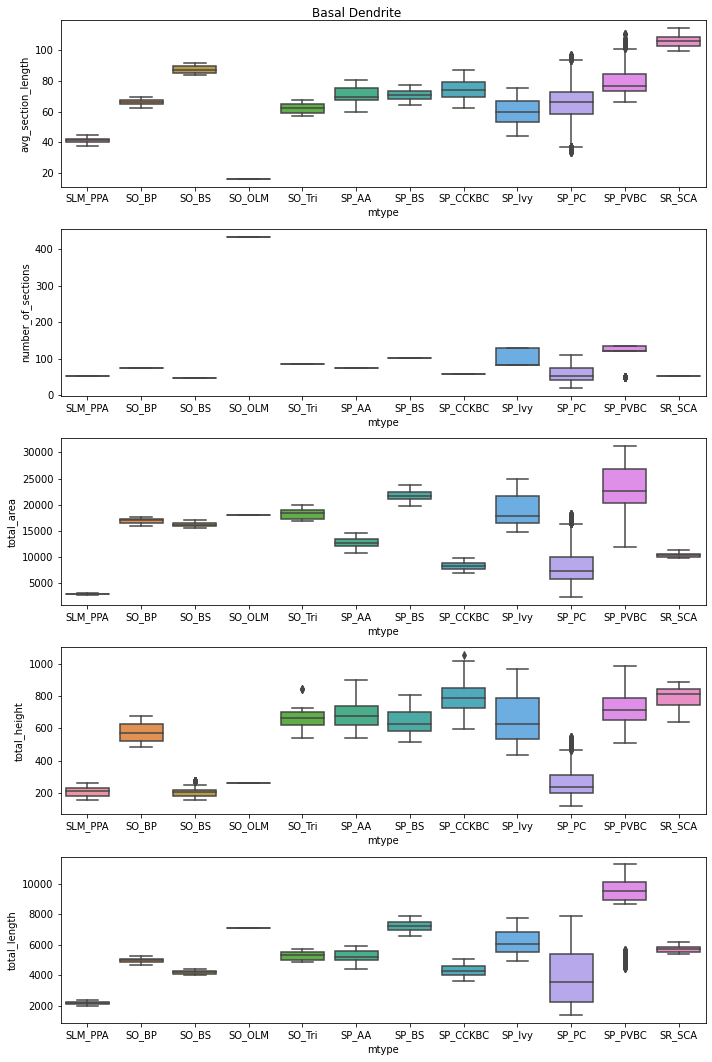

In [24]:
f = plt.subplots(len(FEATURES),1,figsize=(10,15))
for idx,feature_name in enumerate(np.unique(df_features['feature_name'])):
    plt.subplot(len(FEATURES),1,idx+1)
    dff = df_features.etl.q(feature_name=feature_name,loc='basal')
    sns.boxplot(data=dff, x="mtype", y="feature_val")
    plt.ylabel(feature_name)
    
plt.suptitle('Basal Dendrite')
plt.tight_layout()

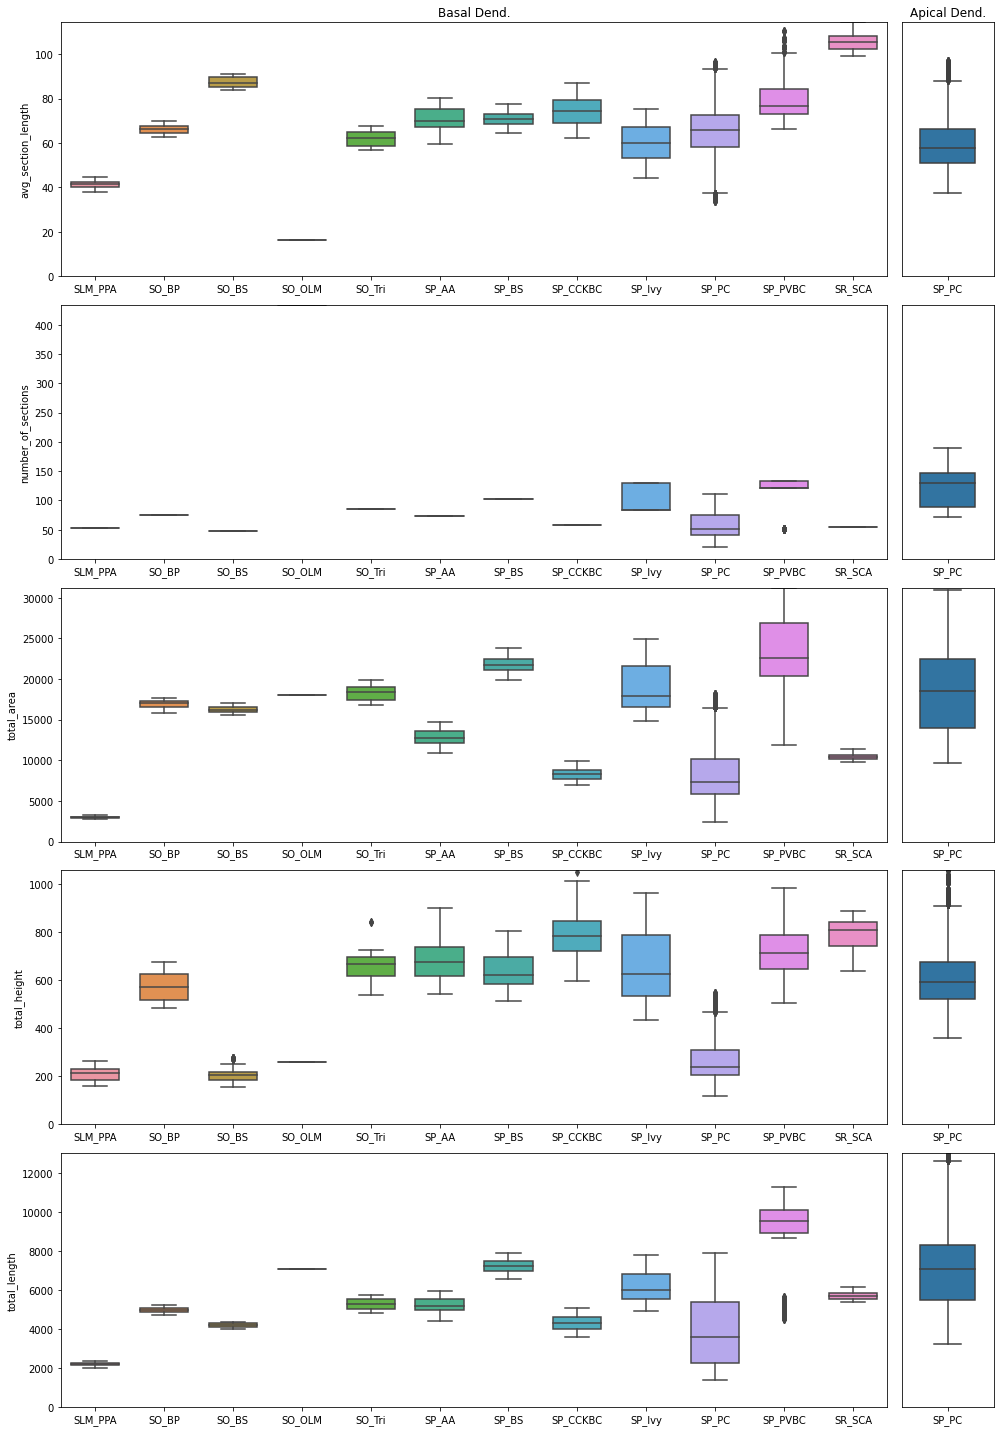

In [24]:
f = plt.subplots(len(FEATURES),2,figsize=(14,20),gridspec_kw={'width_ratios': [9, 1]})


for idx,feature_name in enumerate(np.unique(df_features['feature_name'])):
    df_basal = df_features.etl.q(feature_name=feature_name,loc='basal')
    df_apic = df_features.etl.q(feature_name=feature_name,loc='apical')

    max_val = max(np.max(df_basal['feature_val'].values),np.max(df_apic['feature_val'].values))

    plt.subplot(len(FEATURES),2,2*idx+1)
    sns.boxplot(data=df_basal, x="mtype", y="feature_val",width=0.7).set(xlabel='', ylabel='')
    plt.ylim([0,max_val])

    plt.ylabel(feature_name)
    
    if idx == 0:
        plt.title('Basal Dend.')


    plt.subplot(len(FEATURES),2,2*idx+2)
    sns.boxplot(data=df_apic, x="mtype", y="feature_val",width=0.6).set(xlabel='', ylabel='')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.ylim([0,max_val])
    
    if idx == 0:
        plt.title('Apical Dend.')

plt.tight_layout()

plt.savefig('output/basic_features_clones.png')
plt.savefig('output/basic_features_clones.svg')

In [14]:
FEATURES = ["total_length", "total_height", "total_area", "number_of_sections", "section_lengths"]
NEURITES = {"apical": nm.core.types.NeuriteType.apical_dendrite,
            "basal": nm.core.types.NeuriteType.basal_dendrite,
            "axon": nm.core.types.NeuriteType.axon}

features = {"mtype": [], "feature_name": [], "feature_val": [], "loc": []}

for mtype, paths in mt_samples.items():
    
    morph = nm.load_morphology(mt_samples[mtype])
    for neurite_name, neurite_id in NEURITES.items():
        if mtype != 'SP_PC' and neurite_name=='apical':
            continue
        for feature in FEATURES:
                features["mtype"].append(mtype)
                feature_name = "avg_section_length" if feature == "section_lengths" else feature
                features["feature_name"].append(feature_name)
                feature_val = nm.get(feature, morph, neurite_type=neurite_id)
                feature_val = np.mean(feature_val) if feature == "section_lengths" else feature_val
                features["feature_val"].append(feature_val)
                features["loc"].append(neurite_name)

df_features = pd.DataFrame.from_dict(features)

TypeError: expected str, bytes or os.PathLike object, not list

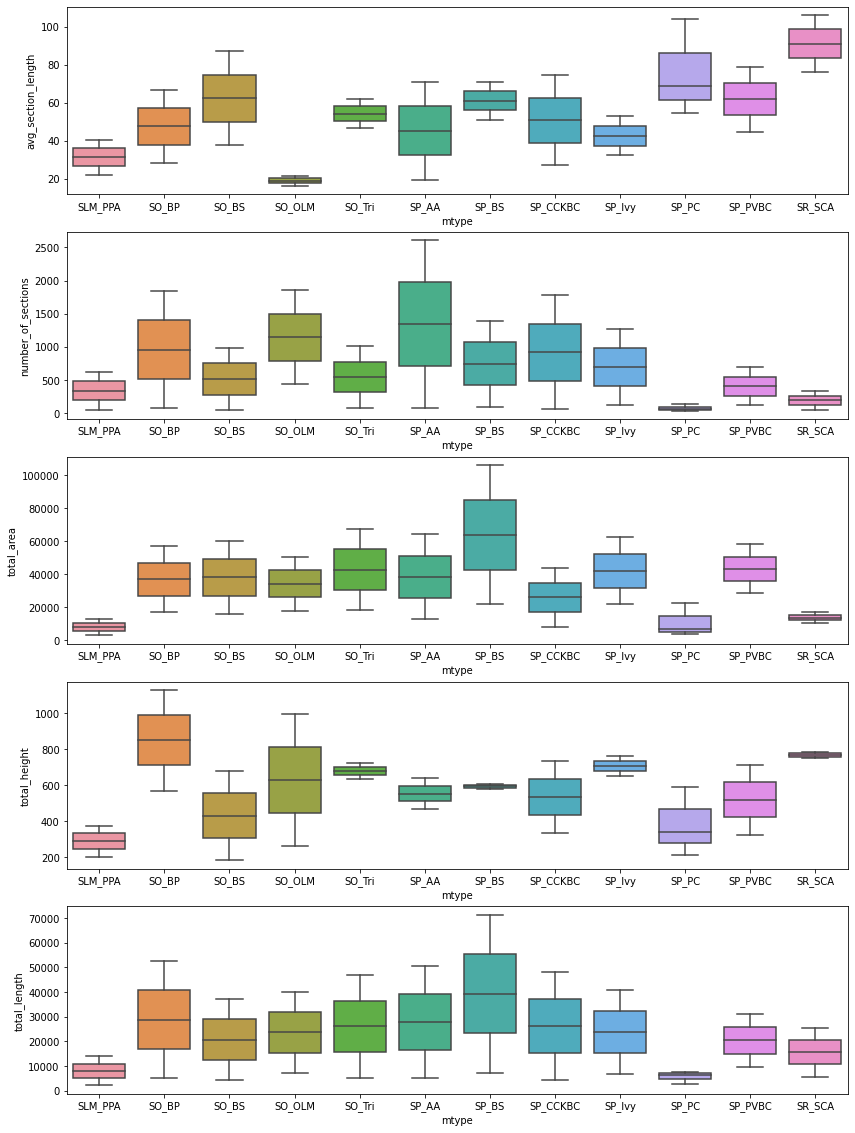

In [183]:
f = plt.subplots(len(FEATURES),1,figsize=(14,20))
for idx,feature_name in enumerate(np.unique(features['feature_name'])):
    plt.subplot(len(FEATURES),1,idx+1)
    dff = df_features[df_features.feature_name==feature_name]
    #dff = df_features.etl.q(feature_name=FEATURES[0],loc='basal')

    sns.boxplot(data=dff, x="mtype", y="feature_val")
    plt.ylabel(feature_name)

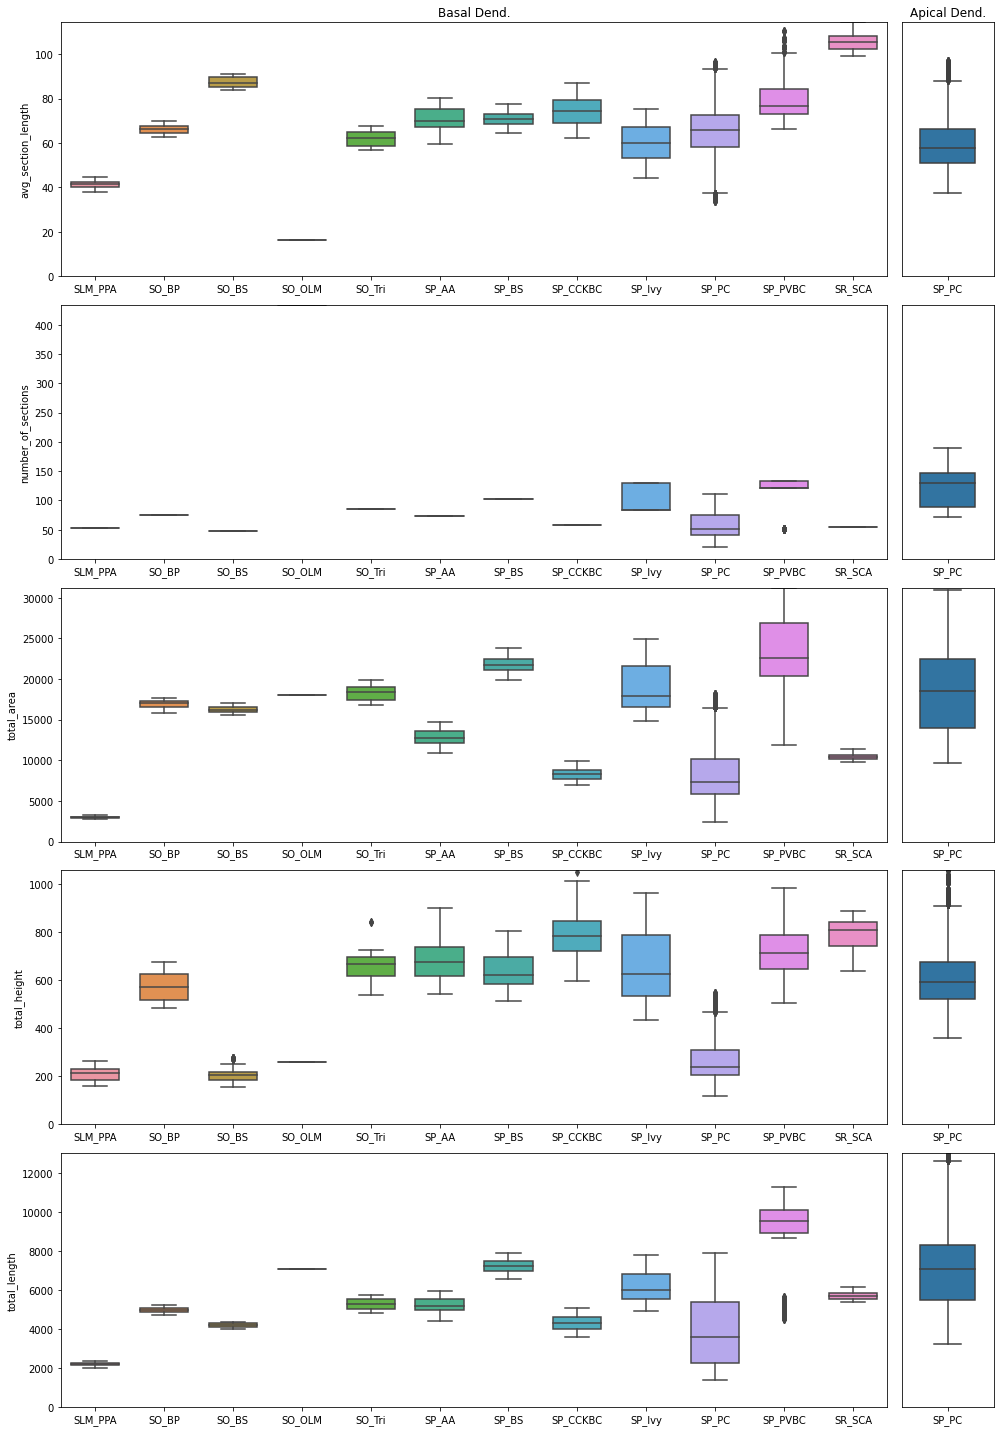

In [25]:
f = plt.subplots(len(FEATURES),2,figsize=(14,20),gridspec_kw={'width_ratios': [9, 1]})

cur_df = orig_features
for idx,feature_name in enumerate(np.unique(cur_df['feature_name'])):
    df_basal = cur_df.etl.q(feature_name=feature_name,loc='basal')
    df_apic = cur_df.etl.q(feature_name=feature_name,loc='apical')

    max_val = max(np.max(df_basal['feature_val'].values),np.max(df_apic['feature_val'].values))

    plt.subplot(len(FEATURES),2,2*idx+1)
    sns.boxplot(data=df_basal, x="mtype", y="feature_val",width=0.7).set(xlabel='', ylabel='')
    plt.ylim([0,max_val])

    plt.ylabel(feature_name)
    
    if idx == 0:
        plt.title('Basal Dend.')


    plt.subplot(len(FEATURES),2,2*idx+2)
    sns.boxplot(data=df_apic, x="mtype", y="feature_val",width=0.6).set(xlabel='', ylabel='')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.ylim([0,max_val])
    
    if idx == 0:
        plt.title('Apical Dend.')

plt.tight_layout()

plt.savefig('output/basic_features_orig.png')
plt.savefig('output/basic_features_orig.svg')

# Plot orig, clone side by side

In [104]:
orig_df = orig_features.etl.q(loc=['basal','apical']).copy().assign(data_type='original')
clone_df = df_features.etl.q(loc=['basal','apical']).copy().assign(data_type='clone')

concat_df = pd.concat([orig_df,clone_df])  
#mdf = pd.melt(concat_df, id_vars=['data_type','mtype','loc','feature_name'], value_vars=[('feature_val')])      # MELT

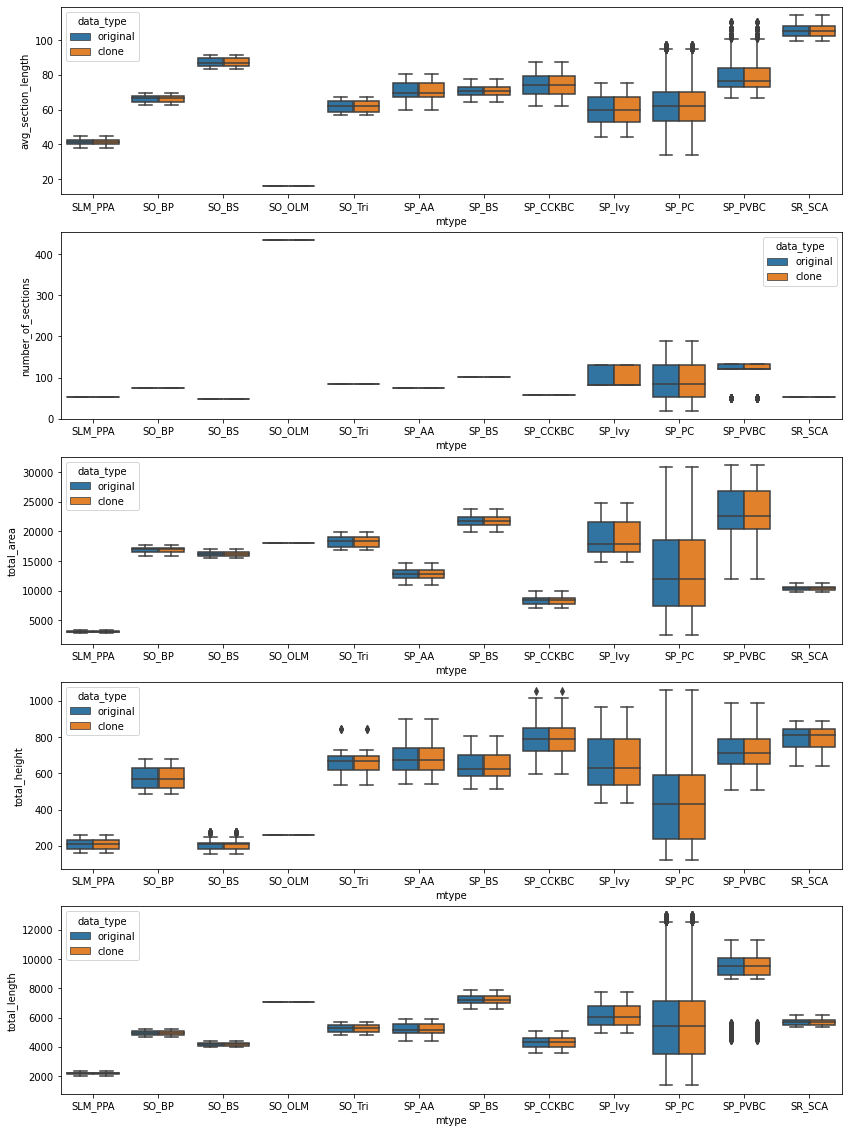

In [105]:
sorted_features = sorted(np.unique(concat_df.feature_name))

f = plt.subplots(len(sorted_features),1,figsize=(14,20))
cur_df = pd.concat([orig_df,clone_df])  

for i in range(len(sorted_features)):
    plt.subplot(len(sorted_features),1,i+1)
    cur_df = concat_df[concat_df.feature_name==sorted_features[i]]
    cur_df = pd.melt(cur_df, id_vars=['data_type','mtype','loc'], value_vars=[('feature_val')])      # MELT
    ax = sns.boxplot(x="mtype", y="value", hue="data_type", data=cur_df)  # RUN PLOT   
    plt.ylabel(sorted_features[i])